# MNIST Digit Classification - Recurrent Neural Network

MNIST images are 28x28. We treat each image as a sequence of 28 rows of pixels, each row of size 28.

In [10]:
from __future__ import division, print_function
from keras.callbacks import ModelCheckpoint
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
DATA_DIR = "../../data"
TRAIN_FILE = os.path.join(DATA_DIR, "mnist_train.csv")
TEST_FILE = os.path.join(DATA_DIR, "mnist_test.csv")

BEST_MODEL = os.path.join(DATA_DIR, "keras-mnist-rnn-best.h5")
FINAL_MODEL = os.path.join(DATA_DIR, "keras-mnist-rnn-final.h5")

COLS, ROWS = 28, 28
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 5

## Prepare Data

In [3]:
def parse_file(filename):
    xdata, ydata = [], []
    fin = open(filename, "rb")
    i = 0
    for line in fin:
        if i % 10000 == 0:
            print("{:s}: {:d} lines read".format(
                os.path.basename(filename), i))
        cols = line.strip().split(",")
        ydata.append(int(cols[0]))
        xpixels = np.reshape(np.array([float(x) / 255. for x in cols[1:]]),
                             (ROWS, COLS))
        xdata.append(xpixels)
        i += 1
    fin.close()
    print("{:s}: {:d} lines read".format(os.path.basename(filename), i))
    Y = np_utils.to_categorical(np.array(ydata), num_classes=NUM_CLASSES)
    X = np.array(xdata)
    return X, Y

Xtrain, Ytrain = parse_file(TRAIN_FILE)
Xtest, Ytest = parse_file(TEST_FILE)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

mnist_train.csv: 0 lines read
mnist_train.csv: 10000 lines read
mnist_train.csv: 20000 lines read
mnist_train.csv: 30000 lines read
mnist_train.csv: 40000 lines read
mnist_train.csv: 50000 lines read
mnist_train.csv: 60000 lines read
mnist_test.csv: 0 lines read
mnist_test.csv: 10000 lines read
(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)


## Define Network

The standard approach to working with text is to input a sequence of word IDs, and then send them into an Embedding layer which converts the word IDs from a one-hot sparse vector representation into a dense dstributed low dimensional representation given by the output size of the embedding.

In this case, since our input is already in the form of a 28 dimensional vector, we will input into the model a sequence of 29 rows of input, each input will be of size 28.

In [4]:
model = Sequential()
model.add(LSTM(512, input_shape=(ROWS, COLS), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1107968   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 1,113,098
Trainable params: 1,113,098
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer="adam", loss="categorical_crossentropy", 
              metrics=["accuracy"])

## Train Network

In [6]:
checkpoint = ModelCheckpoint(filepath=BEST_MODEL, save_best_only=True)
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE, 
                    epochs=NUM_EPOCHS,
                    validation_split=0.1,
                    callbacks=[checkpoint])

/Users/palsujit/anaconda2/lib/python2.7/site-packages/Keras-2.0.4-py2.7.egg/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 255s - loss: 0.4523 - acc: 0.8478 - val_loss: 0.1364 - val_acc: 0.9563

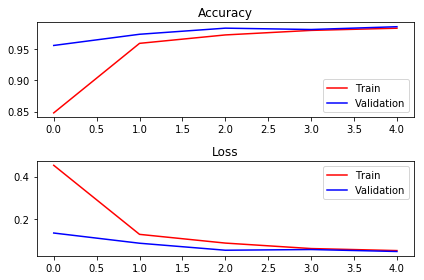

In [7]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="r", label="Train")
plt.plot(history.history["val_acc"], color="b", label="Validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="r", label="Train")
plt.plot(history.history["val_loss"], color="b", label="Validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [8]:
model.save(FINAL_MODEL, overwrite=True)

## Evaluate Network

In [11]:
def evaluate_model(model, model_name):
    print("==== eval {:s} model on test set ====".format(model_name))
    Ytest_ = model.predict(Xtest)
    ytest = np.argmax(Ytest, axis=1)
    ytest_ = np.argmax(Ytest_, axis=1)
    acc = accuracy_score(ytest, ytest_)
    cm = confusion_matrix(ytest, ytest_)
    print("Accuracy: {:.4f}".format(acc))
    print("Confusion Matrix")
    print(cm)

evaluate_model(model, "best")

model = load_model(FINAL_MODEL)
evaluate_model(model, "final")

==== eval best model on test set ====
Accuracy: 0.9840
Confusion Matrix
[[ 968    0    1    0    3    2    3    1    1    1]
 [   0 1123    2    2    1    1    4    0    1    1]
 [   1    0 1025    2    0    0    2    0    2    0]
 [   0    0    0 1005    0    3    0    0    2    0]
 [   0    0    0    0  968    0    7    0    0    7]
 [   1    0    0   12    0  876    2    1    0    0]
 [   0    1    0    0    1    8  947    0    1    0]
 [   0    7   13    0    9    1    0  993    0    5]
 [   0    1    3    5    1    8    0    2  953    1]
 [   2    0    0    2    4   10    1    4    4  982]]
==== eval final model on test set ====
Accuracy: 0.9840
Confusion Matrix
[[ 968    0    1    0    3    2    3    1    1    1]
 [   0 1123    2    2    1    1    4    0    1    1]
 [   1    0 1025    2    0    0    2    0    2    0]
 [   0    0    0 1005    0    3    0    0    2    0]
 [   0    0    0    0  968    0    7    0    0    7]
 [   1    0    0   12    0  876    2    1    0    0]
 [   0